In [68]:
import re
import numpy     as np
import pandas    as pd
import geopandas as gpd

from shapely.geometry import Point
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
%matplotlib inline

## Ciudad

In [2]:
barrios = gpd.read_file('barrios/barrios.shp')

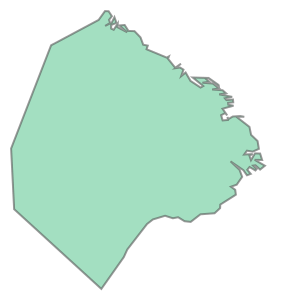

In [31]:
ciudad = barrios.buffer(0.001).unary_union.simplify(100)[1]
ciudad

## Bondis

In [185]:
bondis = gpd.read_file('recorridos/recorridos_de_colectivos.shp')

In [186]:
regexp = re.compile('(?P<línea>\d+) ramal (?P<ramal>\w+) \((?P<sentido>\w+)\)-?(?P<tipo>.*)')

In [187]:
df = bondis.descriptio.apply(lambda x: pd.Series(regexp.match(x).groupdict()))

In [188]:
nuevo_tipo = {'Común Básico':'común',
              'Comun Básico':'común',
              'Expreso':'otro',
              'Diferencial':'otro',
              'Expreso Diferencial':'otro',
              'Fraccionamiento':'otro',
              '':'otro'}

In [189]:
df.tipo = df.tipo.map(nuevo_tipo)

In [190]:
bondis = gpd.GeoDataFrame(df, crs=bondis.crs, geometry=bondis.geometry)

In [191]:
#bondis.geometry = bondis.geometry.intersection(ciudad)
bondis = bondis[bondis.tipo == 'común']

(0.0, 160000.0, 20000.0, 160000.0)

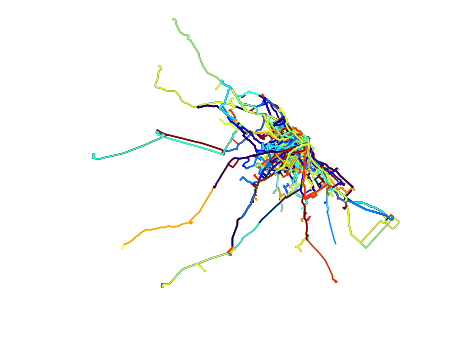

In [192]:
bondis.plot()
plt.axis('off')

## Bondis ciudad

In [158]:
def hex_a(D, ix, iy):
    a = D[iy  ][ix+1]
    b = D[iy-1][ix  ]
    c = D[iy-1][ix-1]
    d = D[iy  ][ix-1]
    e = D[iy+1][ix-1]
    f = D[iy+1][ix  ]
    
    return a, b, c, d, e, f


def hex_b(D, ix, iy):
    a = D[iy  ][ix-1]
    b = D[iy+1][ix  ]
    c = D[iy+1][ix+1]
    d = D[iy  ][ix+1]
    e = D[iy-1][ix+1]
    f = D[iy-1][ix  ]
    
    return a, b, c, d, e, f

In [206]:
xmin, ymin, xmax, ymax = ciudad.bounds

R = 350 # radio hexágonos (metros)

xs = np.arange(xmin - R, xmax + R, R)
ys = np.arange(ymin - np.sqrt(3) / 2 * R, ymax + np.sqrt(3) / 2 * R, np.sqrt(3) / 2 * R)

In [207]:
triangular = np.empty((len(ys), len(xs)), dtype='object')

for ix, x in enumerate(xs):
    for iy, y in enumerate(ys):
        triangular[iy][ix] = (x, y) if iy % 2 == 0 else (x + R / 2, y)

In [208]:
hexagonal = []

for ix in range(1, len(xs) - 1):
    for iy in range(1, len(ys) - 1):
        
        if   iy % 2 == 0 and ix % 3 == 0: # caso A
            hexagonal.append( Polygon(hex_a(triangular, ix, iy)) )
        elif iy % 2 == 1 and ix % 3 == 1: # caso B
            hexagonal.append( Polygon(hex_b(triangular, ix, iy)) )

In [209]:
h = gpd.GeoDataFrame(crs=bondis.crs, geometry=hexagonal)

In [210]:
h = h[h.intersects(ciudad)]

In [213]:
c = gpd.GeoDataFrame(crs=bondis.crs, geometry=h.centroid.buffer(R)) # radio círculos (dos veces el radio de los hexágonos)

In [214]:
guía_t = gpd.sjoin(c, bondis, how='inner', op='intersects')
guía_t.reset_index(inplace=True)
guía_t.rename(columns={'index':'radio', 'index_right':'recorrido'}, inplace=True)
guía_t = guía_t[['radio','recorrido']]

In [215]:
tt = pd.merge(guía_t, guía_t, on='recorrido', suffixes=('_origen', '_destino'))
tt = tt[tt.radio_origen != tt.radio_destino]

In [216]:
h['puntaje'] = tt.groupby('radio_origen').radio_destino.agg(lambda x: x.unique().size)
h.fillna(0, inplace=True)

**EPSG**
* 3857 Google Maps
* 4326 

In [223]:
h[h.puntaje != 0].to_crs({'init': 'epsg:3857'}).to_file('bondis.geojson', driver='GeoJSON')